In [ ]:
%autosave 180
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!pip install catboost
!pip install shap
# !pip install pickle5

In [3]:
from catboost import CatBoostRanker, Pool, MetricVisualizer, cv
import pandas as pd
pd.set_option('max_columns', None)
import os
import gc

# Params

In [4]:
original_cols = [
    'srch_id',
    #     'date_time',  # not used in models
    'site_id',
    'visitor_location_country_id',
    'visitor_hist_starrating',
    'visitor_hist_adr_usd',
    'prop_country_id',
    'prop_id',
    'prop_starrating',
    'prop_review_score',
    'prop_brand_bool',
    'prop_location_score1',
    'prop_location_score2',
    'prop_log_historical_price',
    'price_usd',
    'promotion_flag',
    'srch_destination_id',
    'srch_length_of_stay',
    'srch_booking_window',
    'srch_adults_count',
    'srch_children_count',
    'srch_room_count',
    'srch_saturday_night_bool',
    'srch_query_affinity_score',
    'orig_destination_distance',
    'random_bool',
    #     'comp1_inv',
#     'comp1_rate_percent_diff',
    #     'comp2_inv',
    'comp2_rate_percent_diff',
    #     'comp3_inv',
    'comp3_rate_percent_diff',
    #     'comp4_inv',
#     'comp4_rate_percent_diff',
    #     'comp5_inv',
    'comp5_rate_percent_diff',
    #     'comp6_inv',
#     'comp6_rate_percent_diff',
    #     'comp7_inv',
#     'comp7_rate_percent_diff',
    #     'comp8_inv',
#     'comp8_rate_percent_diff',
]

booking_date_features = [
    'date_time_ordinal',
#     'booking_time_minute',
#     'booking_time_hour',
#     'booking_time_morning',
#     'booking_time_afternoon',
#     'booking_time_evening',
#     'booking_time_late_evening',
#     'booking_time_night',
#     'booking_time_work_hour',
#     'booking_time_lunch',
#     'booking_time_day',
#     'booking_time_is_month_start',
#     'booking_time_is_month_end',
#     'booking_time_dow',
#     'booking_time_is_weekend',
#     'booking_time_doy',
#     'booking_time_week',
#     'booking_time_week_mid_summer_index',
#     'booking_time_month',
#     'booking_time_days_in_month',
#     'booking_time_quarter',
#     'booking_time_is_quarter_start',
#     'booking_time_is_quarter_end',
#     'booking_time_season_num',
#     'booking_time_year',
#     'booking_time_is_year_start',
#     'booking_time_is_year_end',
#     'booking_time_week_id',
#     'booking_time_day_sin',
#     'booking_time_day_cos',
#     'booking_time_month_sin',
#     'booking_time_month_cos',
#     'booking_time_quarter_sin',
#     'booking_time_quarter_cos',
#     'booking_time_week_sin',
#     'booking_time_week_cos',
#     'booking_time_dow_sin',
#     'booking_time_dow_cos',
#     'booking_time_doy_sin',
#     'booking_time_doy_cos',
#     'booking_time_season_num_sin',
#     'booking_time_season_num_cos',
    'holidays_during_booking',
]


prop_location_score_features = [
    'prop_location_score_diff',
#     'prop_location_score_diff_7',
    'prop_location_score_sum',
#     'prop_location_score_sum_7',
    'prop_location_score_mul',
    'prop_location_score_diff_log',
    'prop_location_score_sum_log',
    'prop_location_score_mul_log',
]


competitor_features = [
    'higher_price_than_expedia',
    'lower_price_than_expedia',
    'same_price_as_expedia',
    'comp_num_avail',
    'ratio_of_comp_with_higher_price_than_expedia',
    'ratio_of_comp_with_lower_price_than_expedia',
#     'comp1_rate_percent_diff_signed',
#     'comp2_rate_percent_diff_signed',
#     'comp3_rate_percent_diff_signed',
#     'comp4_rate_percent_diff_signed',
    'comp5_rate_percent_diff_signed',
#     'comp6_rate_percent_diff_signed',
#     'comp7_rate_percent_diff_signed',
    'comp8_rate_percent_diff_signed',

    #  'comp1_rate_percent_diff_log_2',
#     'comp1_rate_percent_diff_log_10',
    #  'comp2_rate_percent_diff_log_2',
#     'comp2_rate_percent_diff_log_10',
    #  'comp3_rate_percent_diff_log_2',
#     'comp3_rate_percent_diff_log_10',
    #  'comp4_rate_percent_diff_log_2',
#     'comp4_rate_percent_diff_log_10',
    #  'comp5_rate_percent_diff_log_2',
#     'comp5_rate_percent_diff_log_10',
    #  'comp6_rate_percent_diff_log_2',
#     'comp6_rate_percent_diff_log_10',
    #  'comp7_rate_percent_diff_log_2',
#     'comp7_rate_percent_diff_log_10',
    #  'comp8_rate_percent_diff_log_2',
#     'comp8_rate_percent_diff_log_10',
]

price_features = [
    'price_per_day',
    'price_per_trip',
    
#     'price_usd_pow_0.33',
    'price_usd_pow_0.5',
    'price_usd_pow_2',
    'price_usd_log_2',
    'price_usd_log_10',
    'price_usd_log_2.72',
    'price_usd_reciprocal',
    
    'visitor_hist_adr_usd_pow_0.33',
    'visitor_hist_adr_usd_pow_0.5',
    'visitor_hist_adr_usd_pow_2',
#     'visitor_hist_adr_usd_log_2',
#     'visitor_hist_adr_usd_log_10',
#     'visitor_hist_adr_usd_log_2.72',
    'visitor_hist_adr_usd_reciprocal',
    
    'prop_log_historical_price_pow_0.33',
#     'prop_log_historical_price_pow_0.5',
#     'prop_log_historical_price_pow_2',
    'prop_log_historical_price_log_2',
    'prop_log_historical_price_log_10',
    'prop_log_historical_price_log_2.72',
    'prop_log_historical_price_reciprocal',
    
#     'price_per_trip_pow_0.33',
#     'price_per_trip_pow_0.5',
#     'price_per_trip_pow_2',
#     'price_per_trip_log_2',
#     'price_per_trip_log_10',
#     'price_per_trip_log_2.72',
#     'price_per_trip_reciprocal',
    
    'price_diff_to_usr_hist',
    'price_ratio_to_usr_hist',
    'price_diff_to_place_hist_price',
    'place_hist_price_diff_usr_hist',
]


star_features = ['prop_star_usr_hist_diff',
                 'prop_review_usr_hist_diff',
                 'prop_starrating_bonus_chain',
                 'prop_star_review_sum',
                 'prop_star_review_diff',
                 'prop_star_review_min',
                 'prop_star_review_max',
                 'prop_star_review_mean', ]

price_star_features = ['price_per_star',
                       'price_per_review_score',
                       'usr_price_per_star',
                       'price_per_star_diff_with_usr',
                       'price_per_review_diff_with_usr',
                       'price_per_star_log_10',
                       'price_per_review_score_log_10',
                       'usr_price_per_star_log_10',
                       ]


trip_detail_features = [
    'travel_inside',
    'trans_ocean',
    'booking_weeks_ahead',
    'booking_months_ahead',
    'len_of_stay_to_booking_ahead_ratio',
#     'len_of_stay_to_booking_ahead_diff',
    'srch_length_of_stay_in_weeks',
    #     'date',
    #     'trip_start_date',
    #     'trip_end_date',
    'holidays_during_trip',
    'business_trip',
    'children_per_adult',
    'total_people',
    'people_per_room',
    'separate_children_room'
]


aggregate_features = [
    'price_index_per_srch_id',
    'price_index_per_srch_destination_id',
    #     'price_index_per_prop_id',
    #     'mean_click_bool_per_prop_id',
    #     'mean_booking_bool_per_prop_id',
    #     'mean_srch_query_affinity_score',
    #     'mean_position_per_prop_id',
]

uncategorized_features = [
    'was_sold_in_that_period',
    'srch_query_affinity_score_prob'
]

##### AGGREGATION FEATURES #####
per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter = [
#     'mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
#     'min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
#     'max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter']


per_visitor_location_country_id_per_prop_id = [
    'mean_price_per_day_per_visitor_location_country_id_per_prop_id',
    'median_price_per_day_per_visitor_location_country_id_per_prop_id',
#     'min_price_per_day_per_visitor_location_country_id_per_prop_id',
    'max_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id',
    'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id',

#     'mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
#     'median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
#     'min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
#     'max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
#     'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter'
]

per_day_per_prop_id_per_trip_start_date_quarter = [
    'mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
#     'median_price_per_day_per_prop_id_per_trip_start_date_quarter',
#     'min_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'max_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter'
]

per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter = [
    'mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
#     'max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_median_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_min_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter',
    'price_per_day_rel_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter'
]

per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2 = [
    'mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
#     'median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
#     'price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2',
    'price_per_day_rel_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2'
]

cols_to_use = (original_cols + booking_date_features + prop_location_score_features +
                  competitor_features + price_features +
                  trip_detail_features + aggregate_features + uncategorized_features +
                  star_features + price_star_features +
                  per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter +
                  per_visitor_location_country_id_per_prop_id +
                  per_day_per_prop_id_per_trip_start_date_quarter +
                  per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter +
                  per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2)

len(cols_to_use)

155

In [5]:
assert len(cols_to_use) == len(set(cols_to_use)), 'some columns are duplicated'

In [6]:
CAT_FEATURES = ['srch_id',
                'site_id',
                'visitor_location_country_id',
                'prop_country_id',
                'prop_id',
                'srch_destination_id',
                'week_id', 
                'season_num', 'day', 'month', 'year', 'quarter', 'week', 'dow'
               ]

CAT_FEATURES = [c for c in CAT_FEATURES if c in cols_to_use]

# bool_cols = ['prop_brand_bool',
#              'promotion_flag',
#              'srch_saturday_night_bool',
#              'random_bool']

# drop_cols = ['usr_extra_pay']

group_col = 'srch_id'
predict_item_col = 'prop_id'

DROP_DATETIME_TYPE = True

# Read data

In [7]:
data_path = '../input/expedia-with-aggregated-features-15-may' # 'data'

In [8]:
# import pickle5 as pickle
# def read_pickled_df(path):
#     with open(path, "rb") as fh:
#         df = pickle.load(fh)
#     return df

In [9]:
# 15.05.2022 Oleg: for feature listing purposes. Do not used in modeling

# val_df = pd.read_pickle(os.path.join(data_path, 'X_val.pickle'))

# cols = val_df.columns.to_list()
# cols = [c for c in cols if 'per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter' not in c]
# cols = [c for c in cols if 'per_day_per_visitor_location_country_id_per_prop_id' not in c]
# cols = [c for c in cols if 'per_day_per_prop_id_per_trip_start_date_quarter' not in c]
# cols = [c for c in cols if 'per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter' not in c]
# cols = [c for c in cols if 'per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2' not in c]
# # [c for c in cols if 'per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2' in c]
# cols



In [10]:
# X_train = read_pickled_df(os.path.join(data_path, 'X_train.pickle'), usecols=cols_to_use).reset_index(drop=True)
# y_train = read_pickled_df(os.path.join(data_path, 'y_train.pickle')).reset_index(drop=True)
X_train = pd.read_feather(os.path.join(data_path, 'X_train.feather'), columns=cols_to_use)
y_train = pd.read_feather(os.path.join(data_path, 'y_train.feather'))['target']
# X_train = X_train[cols_to_use]

if DROP_DATETIME_TYPE:
    X_train = X_train.select_dtypes(exclude=['datetime64[ns]'])

print('X_train.shape', X_train.shape)
X_train.head()

X_train.shape (3969251, 155)


,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp2_rate_percent_diff,comp3_rate_percent_diff,comp5_rate_percent_diff,date_time_ordinal,holidays_during_booking,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,higher_price_than_expedia,lower_price_than_expedia,same_price_as_expedia,comp_num_avail,ratio_of_comp_with_higher_price_than_expedia,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day,price_per_trip,price_usd_pow_0.5,price_usd_pow_2,price_usd_log_2,price_usd_log_10,price_usd_log_2.72,price_usd_reciprocal,visitor_hist_adr_usd_pow_0.33,visitor_hist_adr_usd_pow_0.5,visitor_hist_adr_usd_pow_2,visitor_hist_adr_usd_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_2,prop_log_historical_price_log_10,prop_log_historical_price_log_2.72,prop_log_historical_price_reciprocal,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_diff_to_place_hist_price,place_hist_price_diff_usr_hist,travel_inside,trans_ocean,booking_weeks_ahead,booking_months_ahead,len_of_stay_to_booking_ahead_ratio,srch_length_of_stay_in_weeks,holidays_during_trip,business_trip,children_per_adult,total_people,people_per_room,separate_children_room,price_index_per_srch_id,price_index_per_srch_destination_id,was_sold_in_that_period,srch_query_affinity_score_prob,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,usr_price_per_star,price_per_star_diff_with_usr,price_per_review_diff_with_usr,price_per_star_log_10,price_per_review_score_log_10,usr_price_per_star_log_10,median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_mean_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_median_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_min_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,price_per_day_rel_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,mean_price_per_day_per_visitor_location_country_id_per_prop_id,median_price_per_day_per_visitor_location_country_id_per_prop_id,max_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_rel_diff_to_mean_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_rel_diff_to_median_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_rel_diff_to_min_price_per_day_per_visitor_location_country_id_per_prop_id,price_per_day_diff_to_max_price_per

In [11]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [12]:
X_train.memory_usage().sum() / 1024**2

2093.3112440109253

In [13]:
# # makes sure all features are categorized
# assert set() == set(X_train.columns) - set(original_cols + booking_date_features + prop_location_score_features + competitor_features + price_features + historical_price_features + trip_detail_features + aggregate_features + uncategorized_features)

In [14]:
X_train.dtypes.value_counts()#.apply(lambda x: x.name).to_dict()

float32    128
uint8       16
bool         5
uint32       4
uint16       2
dtype: int64

In [15]:
train_pool = Pool(data=X_train, 
                  label=y_train,
                  group_id=X_train[group_col],
                  cat_features=CAT_FEATURES,
                  )
del X_train, y_train; gc.collect()

69

In [16]:
# X_val = read_pickled_df(os.path.join(data_path, 'X_val.pickle'), usecols=cols_to_use).reset_index(drop=True)
# y_val = read_pickled_df(os.path.join(data_path, 'y_val.pickle')).reset_index(drop=True)
X_val = pd.read_feather(os.path.join(data_path, 'X_val.feather'), columns=cols_to_use)
y_val = pd.read_feather(os.path.join(data_path, 'y_val.feather'))['target']
# X_val = X_val[cols_to_use]

if DROP_DATETIME_TYPE:
    X_val = X_val.select_dtypes(exclude=['datetime64[ns]'])
    
print('X_val.shape', X_val.shape)

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

del X_val, y_val; gc.collect()

X_val.shape (496664, 155)


0

# Fit final model

In [17]:
import catboost
catboost.__version__

'1.0.5'

In [18]:
gc.collect()

46

In [19]:
params = {
    "iterations": 5500, # make 1500
    'loss_function': 'YetiRank', # YetiRankPairwise should be better
#     'custom_metric': ['NDCG:top=5;type=Base;denominator=LogPosition;hints=skip_train~false'], # :
    "verbose": False,
    'early_stopping_rounds': 400,
    'use_best_model': True,
#     'metric_period': 50,
    "task_type": "GPU",
#     'save_snapshot': True,
#     'snapshot_interval': 600, 
}

In [20]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=val_pool, plot=False, verbose_eval=True)

Groupwise loss function. OneHotMaxSize set to 10


Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4123677	best: 0.4123677 (0)	total: 488ms	remaining: 44m 45s
1:	test: 0.4245463	best: 0.4245463 (1)	total: 959ms	remaining: 43m 55s
2:	test: 0.4434559	best: 0.4434559 (2)	total: 1.43s	remaining: 43m 35s
3:	test: 0.4451192	best: 0.4451192 (3)	total: 1.9s	remaining: 43m 25s
4:	test: 0.4457601	best: 0.4457601 (4)	total: 2.36s	remaining: 43m 18s
5:	test: 0.4502314	best: 0.4502314 (5)	total: 2.83s	remaining: 43m 15s
6:	test: 0.4505756	best: 0.4505756 (6)	total: 3.3s	remaining: 43m 11s
7:	test: 0.4523957	best: 0.4523957 (7)	total: 3.77s	remaining: 43m 10s
8:	test: 0.4564473	best: 0.4564473 (8)	total: 4.24s	remaining: 43m 9s
9:	test: 0.4578562	best: 0.4578562 (9)	total: 4.72s	remaining: 43m 9s
10:	test: 0.4575597	best: 0.4578562 (9)	total: 5.19s	remaining: 43m 8s
11:	test: 0.4576104	best: 0.4578562 (9)	total: 5.66s	remaining: 43m 7s
12:	test: 0.4575503	best: 0.4578562 (9)	total: 6.14s	remaining: 43m 11s
13:	test: 0.4642611	best: 0.4642611 (13)	total: 6.61s	remaining: 43m 10s
14:	tes

In [ ]:
model.save_model('catboost_model')

In [24]:
from IPython.display import FileLink
FileLink(r'catboost_model')

/kaggle/working/catboost_model

In [25]:
!zip -r catboost_info.zip /kaggle/working/catboost_info/

  adding: kaggle/working/catboost_info/ (stored 0%)
  adding: kaggle/working/catboost_info/tmp/ (stored 0%)
  adding: kaggle/working/catboost_info/catboost_training.json (deflated 78%)
  adding: kaggle/working/catboost_info/time_left.tsv (deflated 55%)
  adding: kaggle/working/catboost_info/learn_error.tsv (stored 0%)
  adding: kaggle/working/catboost_info/learn/ (stored 0%)
  adding: kaggle/working/catboost_info/learn/events.out.tfevents (stored 0%)
  adding: kaggle/working/catboost_info/test_error.tsv (deflated 61%)
  adding: kaggle/working/catboost_info/test/ (stored 0%)
  adding: kaggle/working/catboost_info/test/events.out.tfevents (deflated 81%)


# Eval

In [ ]:
model = CatBoostRanker()
model.load_model('catboost_model', format='cbm')

In [ ]:
# from catboost.utils import eval_metric
# In ranking tasks it is not necessary to predict the same labels.
# It is important to predict the right order of objects.
# eval_metric(labels, good_predictions, 'NDCG:top=5;type=Base;denominator=LogPosition', 
#             group_id=group_ids)

In [26]:
print(model.eval_metrics(val_pool,
                   'NDCG:top=5;type=Base;denominator=LogPosition',
                   ntree_start=model.tree_count_-1))
del val_pool; gc.collect()

{'NDCG:top=5;type=Base': [0.39704181194531485]}


1326

In [ ]:
print(model.eval_metrics(train_pool,
                   'NDCG:top=5;type=Base;denominator=LogPosition',
                   ntree_start=model.tree_count_-1))

del train_pool; gc.collect()

In [22]:
# X_val = read_pickled_df(os.path.join(data_path, 'X_val.pickle'), usecols=cols_to_use).reset_index(drop=True)
# y_val = read_pickled_df(os.path.join(data_path, 'y_val.pickle')).reset_index(drop=True)
X_test = pd.read_feather(os.path.join(data_path, 'X_test.feather'), columns=cols_to_use)
y_test = pd.read_feather(os.path.join(data_path, 'y_test.feather'))['target']


print('X_test.shape', X_test.shape)

test_pool = Pool(data=X_test,
                label=y_test,
                group_id=X_test[group_col],
                cat_features=CAT_FEATURES,
                )

print(model.eval_metrics(test_pool,
                         'NDCG:top=5;type=Base;denominator=LogPosition',
                         ntree_start=model.tree_count_-1))

del X_test, y_test; gc.collect()

X_test.shape (492432, 163)
{'NDCG:top=5;type=Base': [0.38654798749966246]}


0

# Retrain the model on train+val, with test set as eval. The hyper parameters are frozen!  

Uncomment at the end of the competition

In [ ]:
# train_val_pool = Pool(data=pd.concat([X_train, X_val], axis=0),
#                       label=data=pd.concat([y_train, y_val], axis=0),
#                       group_id=pd.concat([X_train, X_val], axis=0)[group_col],
#                       cat_features=CAT_FEATURES,
#                       )

In [ ]:
# params["iterations"] += 1000

# model = CatBoostRanker(**params)
# model.fit(train_val_pool, eval_set=test_pool, plot=False, verbose_eval=True)

# Make preds

In [ ]:
# def predict_in_format(model, data, pool, group_col, predict_item_col, gt_col=None):
#     preds = model.predict(pool)

#     values = {group_col: data[group_col],
#               predict_item_col: data[predict_item_col],
#               'pred': preds}

#     values_df = pd.DataFrame(values)
#     values_df.sort_values(by=[group_col, 'pred'], ascending=[True, False], inplace=True)

#     if gt_col is not None:
#         values_df['gt'] = gt_col
#         ndcg_score = values_df.groupby(group_col)['gt'].apply(ndcg, at=5).mean()
#         print('Local test NDCG@5:', ndcg_score)

#     return values_df

In [ ]:
# subm_df = pd.read_pickle(os.path.join(data_path, 'submission_df_preprocessed.pickle'))
# subm_df.sort_values([group_col], inplace=True)

In [ ]:
# subm_name = './submission_11.csv'

In [ ]:
# subm_pool = Pool(
#     data=subm_df,
#     group_id=subm_df[group_col],
#     cat_features=CAT_FEATURES,
# )

# output_df = predict_in_format(model, subm_df, subm_pool, group_col, predict_item_col)
# del subm_df, subm_pool; gc.collect()
# output_df.head(10)

In [ ]:
# output_df[[group_col, 'prop_id']].to_csv(subm_name, index=False)
# del output_df; gc.collect()
# pd.read_csv(subm_name, nrows=10)

In [ ]:
# # use locally or if you added the sample subm file to the dataset
# def validate_submission(subm_sample_path, our_subm_path):
    
#     subm_sample = pd.read_csv(subm_sample_path)
#     our_subm = pd.read_csv(our_subm_path)
    
#     assert subm_sample.shape == our_subm.shape
#     assert our_subm[group_col].equals(subm_sample[group_col])
#     assert our_subm.index.equals(subm_sample.index)
#     assert subm_sample.groupby(group_col)['prop_id'].apply(len).to_frame().equals(
#         our_subm.groupby(group_col)['prop_id'].apply(len).to_frame())
#     print('everything is ok to submit')
    
# validate_submission(os.path.join(data_path, 'submission_sample.csv'),
#                     subm_name)

Score: 0.39492

# Feature importance

In [23]:
# del test_pool; gc.collect()

X_val = pd.read_feather(os.path.join(data_path, 'X_val.feather'), columns=cols_to_use).head(10000)
y_val = pd.read_feather(os.path.join(data_path, 'y_val.feather'))['target'].head(10000)
print('X_val.shape', X_val.shape)

val_pool = Pool(data=X_val,
                label=y_val,
                group_id=X_val[group_col],
                cat_features=CAT_FEATURES,
                )

X_val.shape (10000, 163)


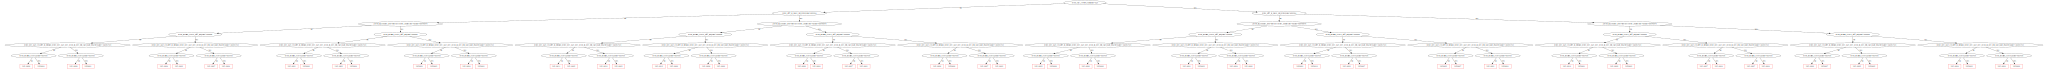

In [24]:
model.plot_tree(
    tree_idx=0,
    pool=val_pool
)

For each feature, LossFunctionChange represents the difference between the loss value of the model with this feature and without it.

+ more accurate than Prediction Values Change
+ more fast than Shap Values
- assumes that loss function changes for several features can be summed up

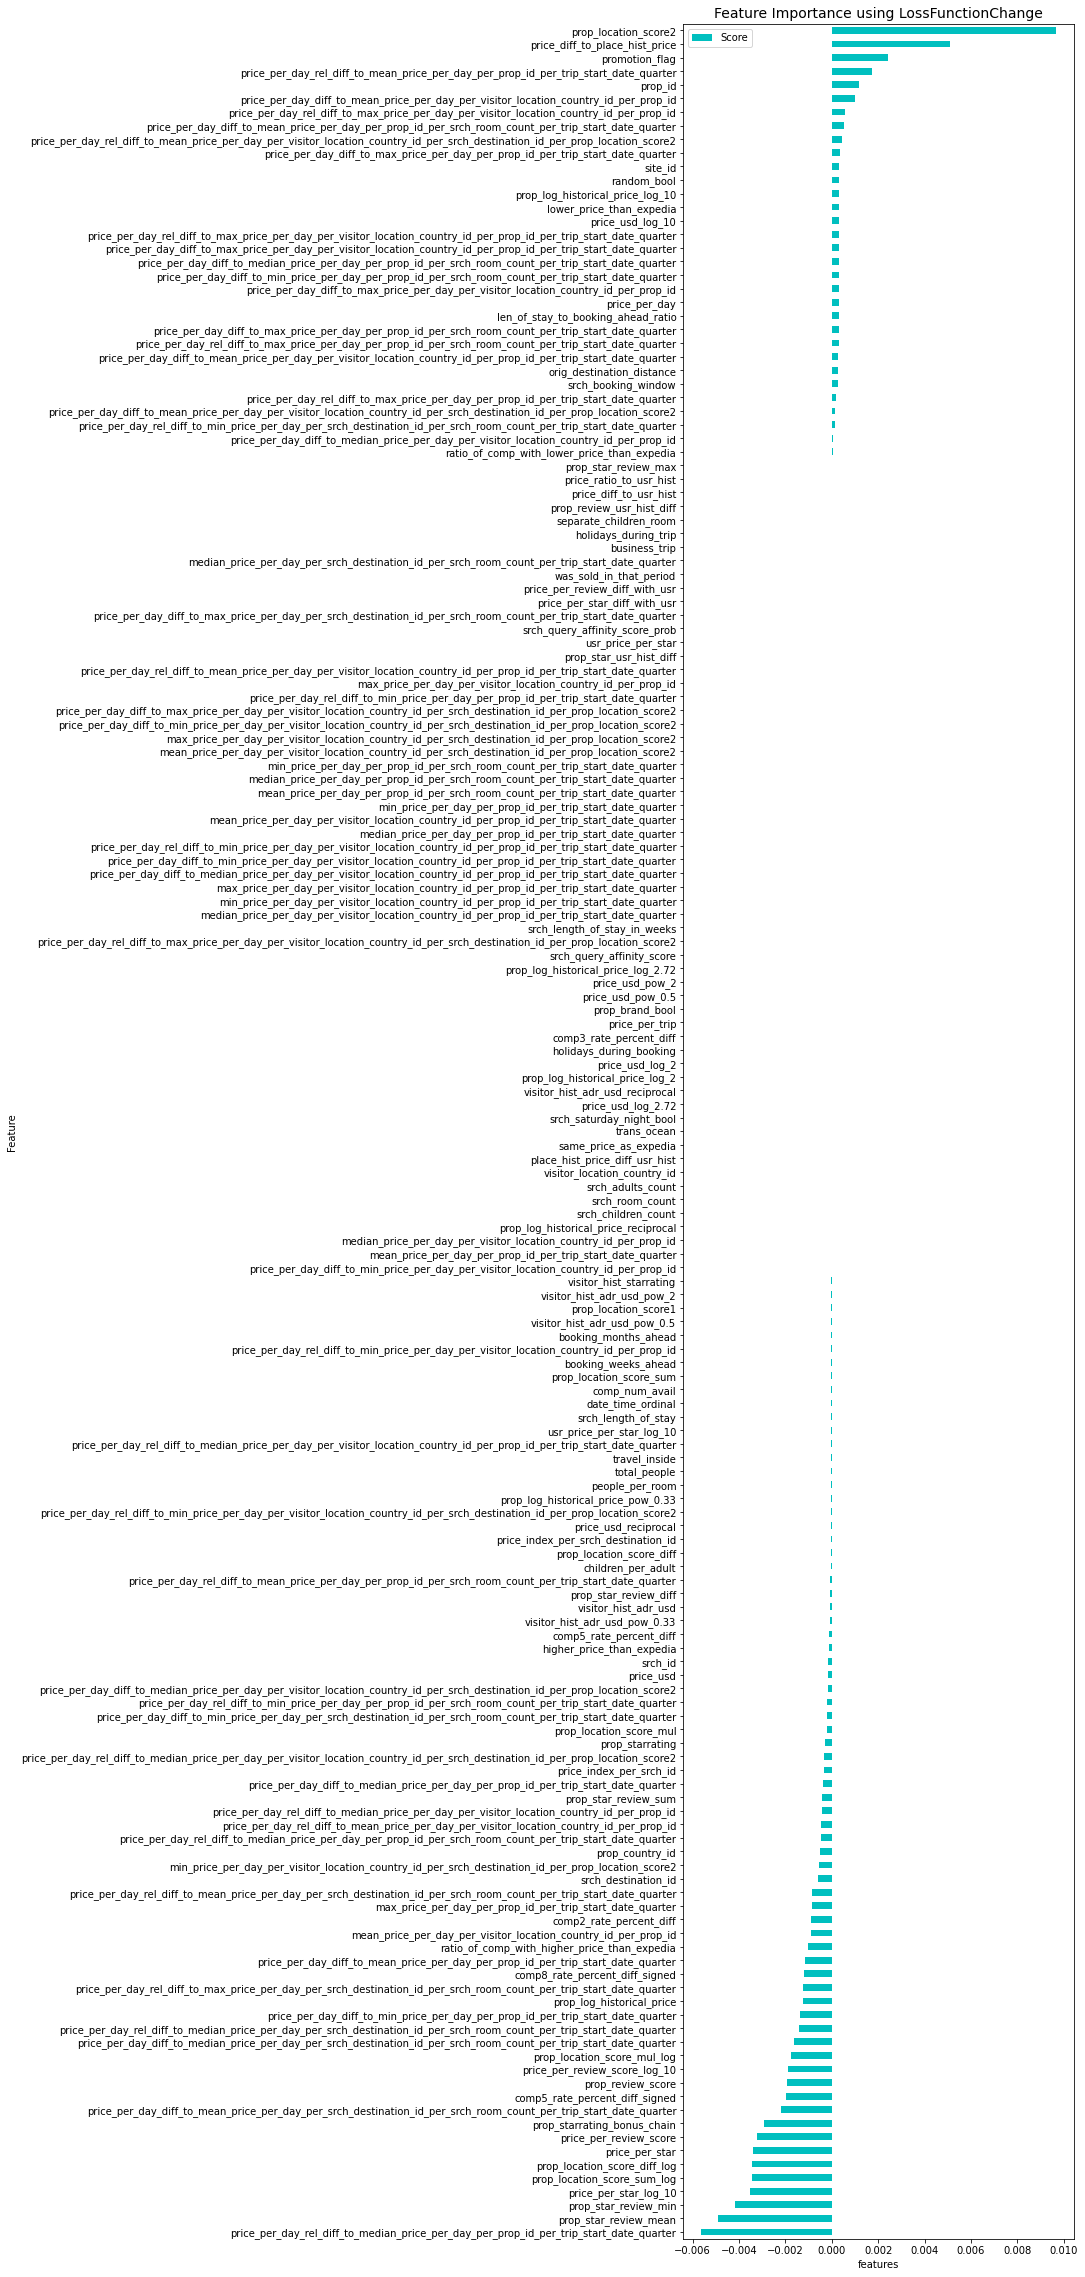

In [25]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange']:
    fi = model.get_feature_importance(val_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_val.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

In [26]:
pd.set_option('max_rows', None)
pd.set_option('display.max_colwidth', None)
feature_score.sort_values('Feature')

,Feature,Score
68,booking_months_ahead,-3.503612e-05
67,booking_weeks_ahead,-3.503612e-05
72,business_trip,0.000000e+00
73,children_per_adult,-4.949734e-05
25,comp2_rate_percent_diff,-8.958016e-04
26,comp3_rate_percent_diff,0.000000e+00
27,comp5_rate_percent_diff,-1.063683e-04
42,comp5_rate_percent_diff_signed,-1.992860e-03
43,comp8_rate_percent_diff_signed,-1.207686e-03
39,comp_num_avail,-3.503612e-05


In [36]:
feature_score['per_col'] = feature_score['Feature'].apply(lambda x: ''.join(x.split('per_')[1:]))
feature_score[feature_score['per_col'] != ''].sort_values('per_col').drop(['per_col'], axis=1)

,Feature,Score
73,children_per_adult,-4.949734e-05
44,price_per_day,3.177907e-04
150,price_per_day_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter,3.125291e-04
139,price_per_day_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter,3.468112e-04
104,price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,0.000000e+00
115,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id,3.177907e-04
127,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter,3.177907e-04
161,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2,0.000000e+00
144,price_per_day_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter,5.271341e-04
133,price_per_day_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter,-1.176328e-03


In [30]:
# from feature_importance import get_and_plot_feature_imp_catboost

# COLLECT_N_IMPORTANT_FEATURES = 150

# feature_score_SHAP, shap_values_raw = get_and_plot_feature_imp_catboost(model, X_val, y_val,
#                                                                         method='SHAP',
#                                                                         cat_features=CAT_FEATURES,
#                                                                         #                                                        plot_type='bar',
#                                                                         top_n=COLLECT_N_IMPORTANT_FEATURES)

# # important_features_collected.update(feature_score_SHAP.sort_values(
# #     ['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])

In [ ]:
pd.set_option('max_rows', None)
feature_score_SHAP.sort_values('Score', ascending=False)

In [ ]:
shap_values_raw

features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

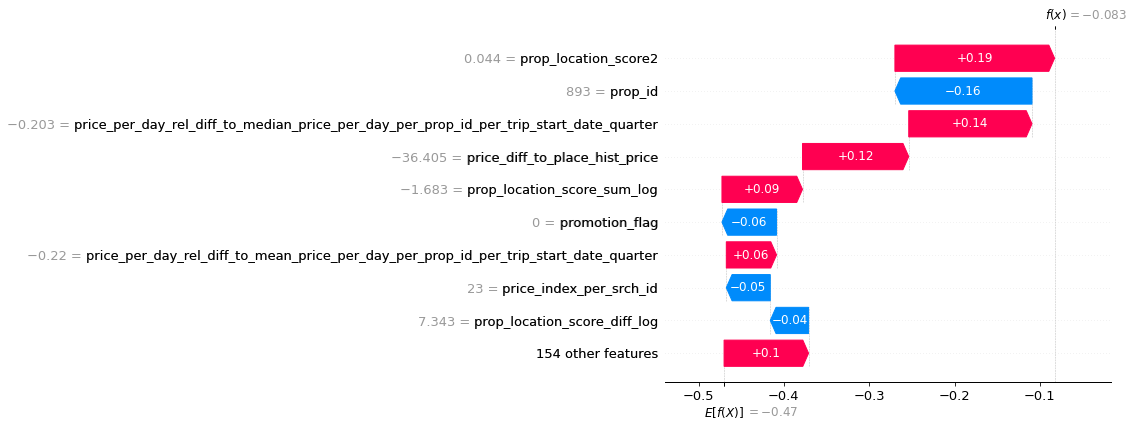

In [37]:
import shap
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap.plots.waterfall(shap_values[0])

# visualize the first prediction's explanation
# shap_values = shap_values_raw[:, :-1]
# shap.plots.waterfall(shap_values_raw[0])

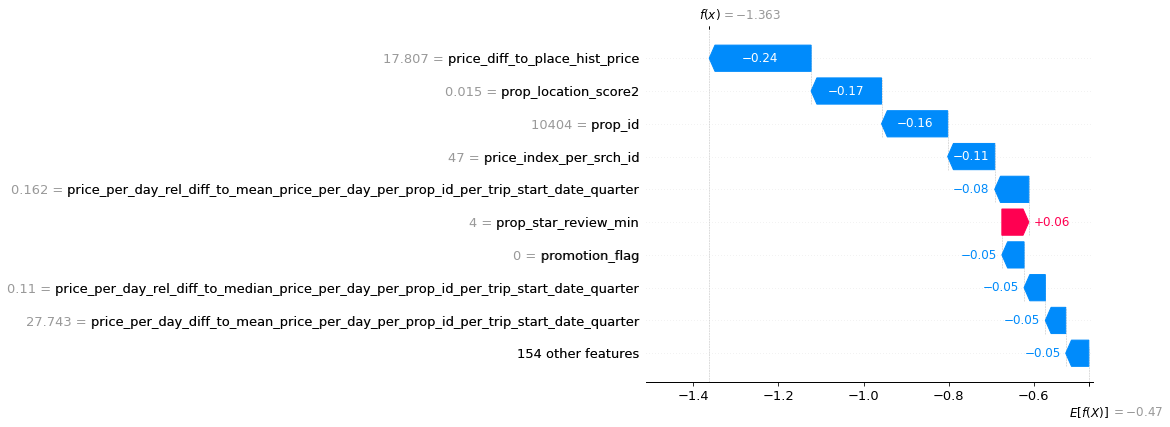

In [38]:
shap.plots.waterfall(shap_values[1])

In [39]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [40]:
shap.plots.force(shap_values[10])

In [41]:
# visualize all the training set predictions
shap.plots.force(shap_values[:10])

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion at a single value represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. 

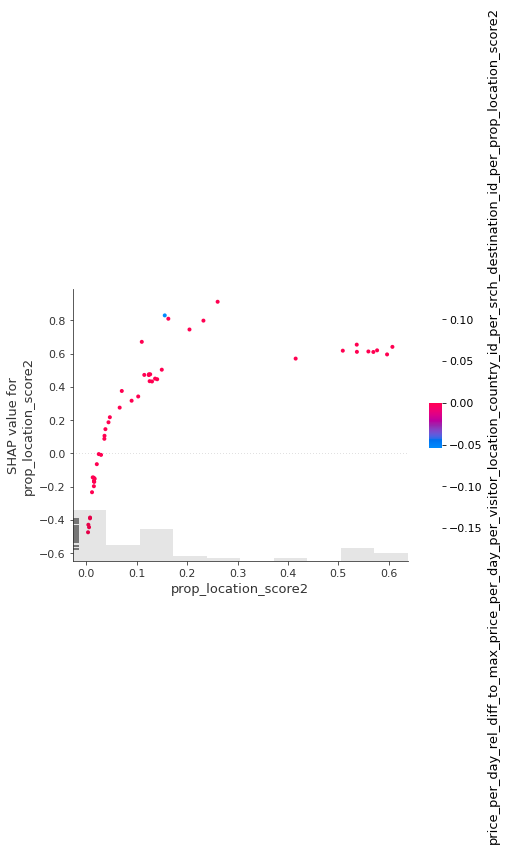

In [45]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:100, "prop_location_score2"], color=shap_values[:100])

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

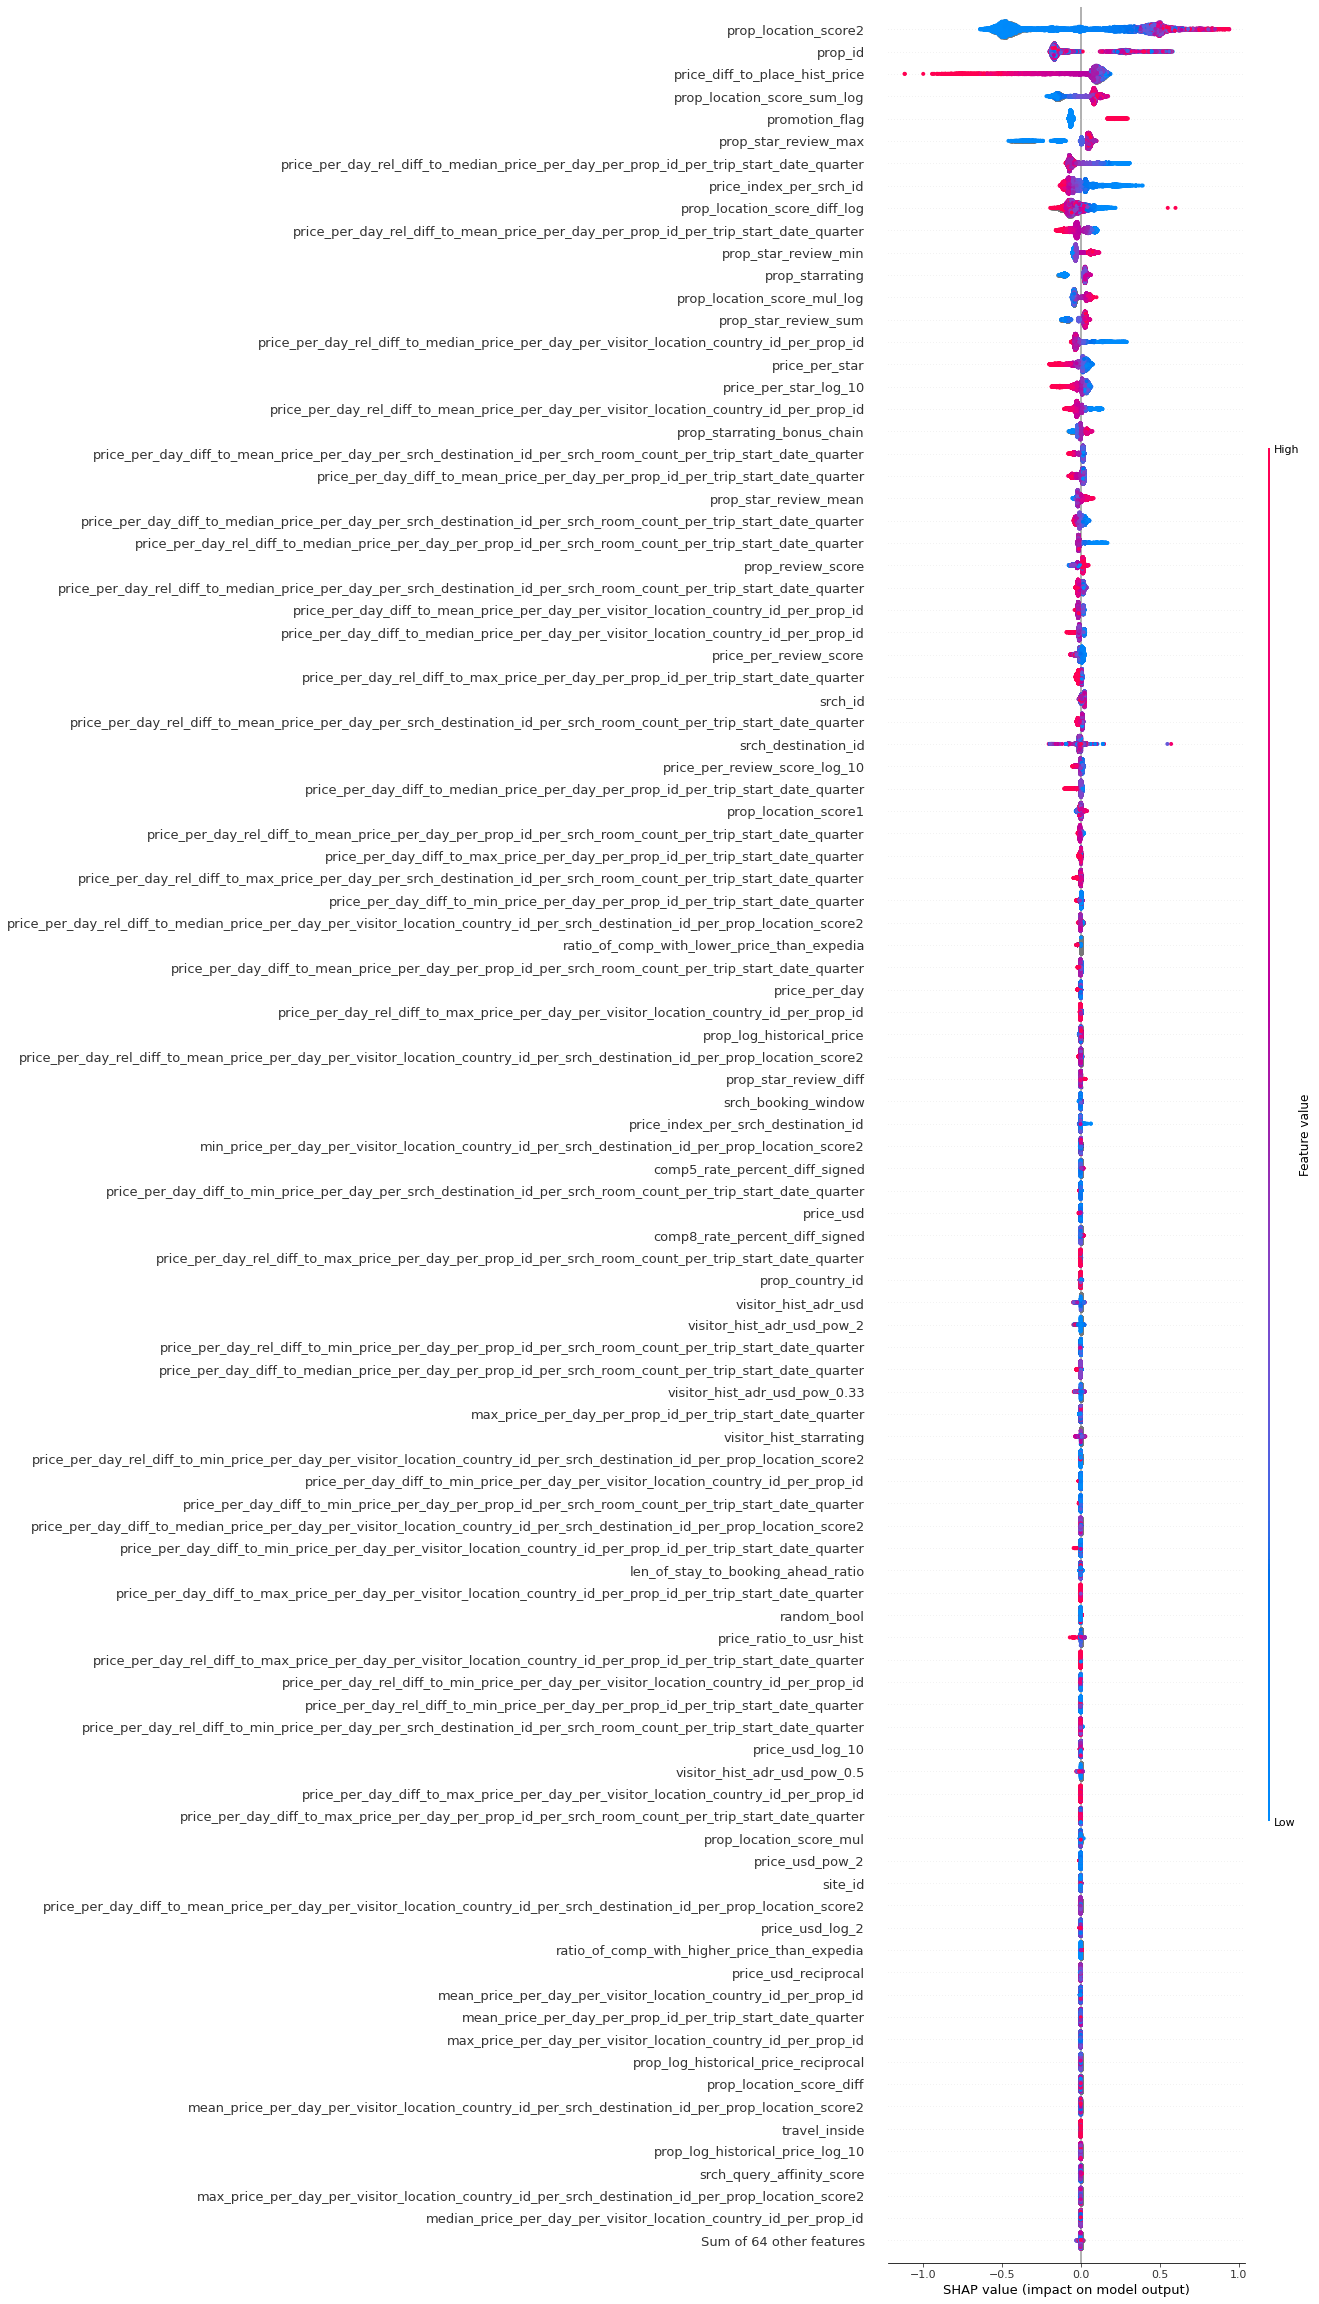

In [51]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=100)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

In [70]:
shap_values.values

array([[ 1.44787562e-02,  1.58314882e-03,  4.48637043e-08, ...,
         8.03504706e-04,  0.00000000e+00, -1.62513270e-04],
       [ 1.64865483e-02, -2.62020215e-03,  4.74933208e-09, ...,
         6.35651005e-04,  0.00000000e+00, -2.15863143e-04],
       [ 1.27404713e-02, -1.21465120e-03,  4.68655216e-08, ...,
         5.97054856e-04,  0.00000000e+00, -3.86662256e-05],
       ...,
       [ 6.15490645e-03,  2.27963690e-04,  2.31747660e-08, ...,
        -5.65923813e-04,  0.00000000e+00, -2.19671701e-04],
       [ 1.83796796e-03,  4.79724008e-04,  3.80636272e-08, ...,
        -1.27544740e-03,  0.00000000e+00,  9.60711750e-05],
       [ 1.84839481e-03,  5.48291075e-04,  3.80636272e-08, ...,
        -9.37154509e-04,  0.00000000e+00,  6.73351162e-05]])

In [82]:
import numpy as np
features = X_val.columns
mean_shaps = np.abs(shap_values.values).mean(0)
# mask = mean_shaps.argsort()[::-1]
# features[mask]
shaps_df = pd.DataFrame({'feature': features, 'shap': mean_shaps})
shaps_df.sort_values('shap', ascending=False)

,feature,shap
11,prop_location_score2,3.990874e-01
6,prop_id,1.967505e-01
63,price_diff_to_place_hist_price,1.614873e-01
34,prop_location_score_sum_log,1.068746e-01
14,promotion_flag,9.571600e-02
87,prop_star_review_max,7.730506e-02
136,price_per_day_rel_diff_to_median_price_per_day_per_prop_id_per_trip_start_date_quarter,7.657878e-02
77,price_index_per_srch_id,7.263311e-02
33,prop_location_score_diff_log,5.949134e-02
134,price_per_day_rel_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter,5.225070e-02


In [87]:
shaps_df['per_col'] = shaps_df['feature'].apply(lambda x: ''.join(x.split('per_')[1:]))
shaps_df[shaps_df['per_col'] != ''].sort_values(['per_col', 'shap']).drop(['per_col'], axis=1)

,feature,shap
73,children_per_adult,0.000224
44,price_per_day,0.002451
150,price_per_day_diff_to_max_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter,0.000580
139,price_per_day_diff_to_max_price_per_day_per_prop_id_per_trip_start_date_quarter,0.004434
104,price_per_day_diff_to_max_price_per_day_per_srch_destination_id_per_srch_room_count_per_trip_start_date_quarter,0.000107
115,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id,0.000629
127,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_prop_id_per_trip_start_date_quarter,0.000842
161,price_per_day_diff_to_max_price_per_day_per_visitor_location_country_id_per_srch_destination_id_per_prop_location_score2,0.000000
144,price_per_day_diff_to_mean_price_per_day_per_prop_id_per_srch_room_count_per_trip_start_date_quarter,0.002871
133,price_per_day_diff_to_mean_price_per_day_per_prop_id_per_trip_start_date_quarter,0.021244


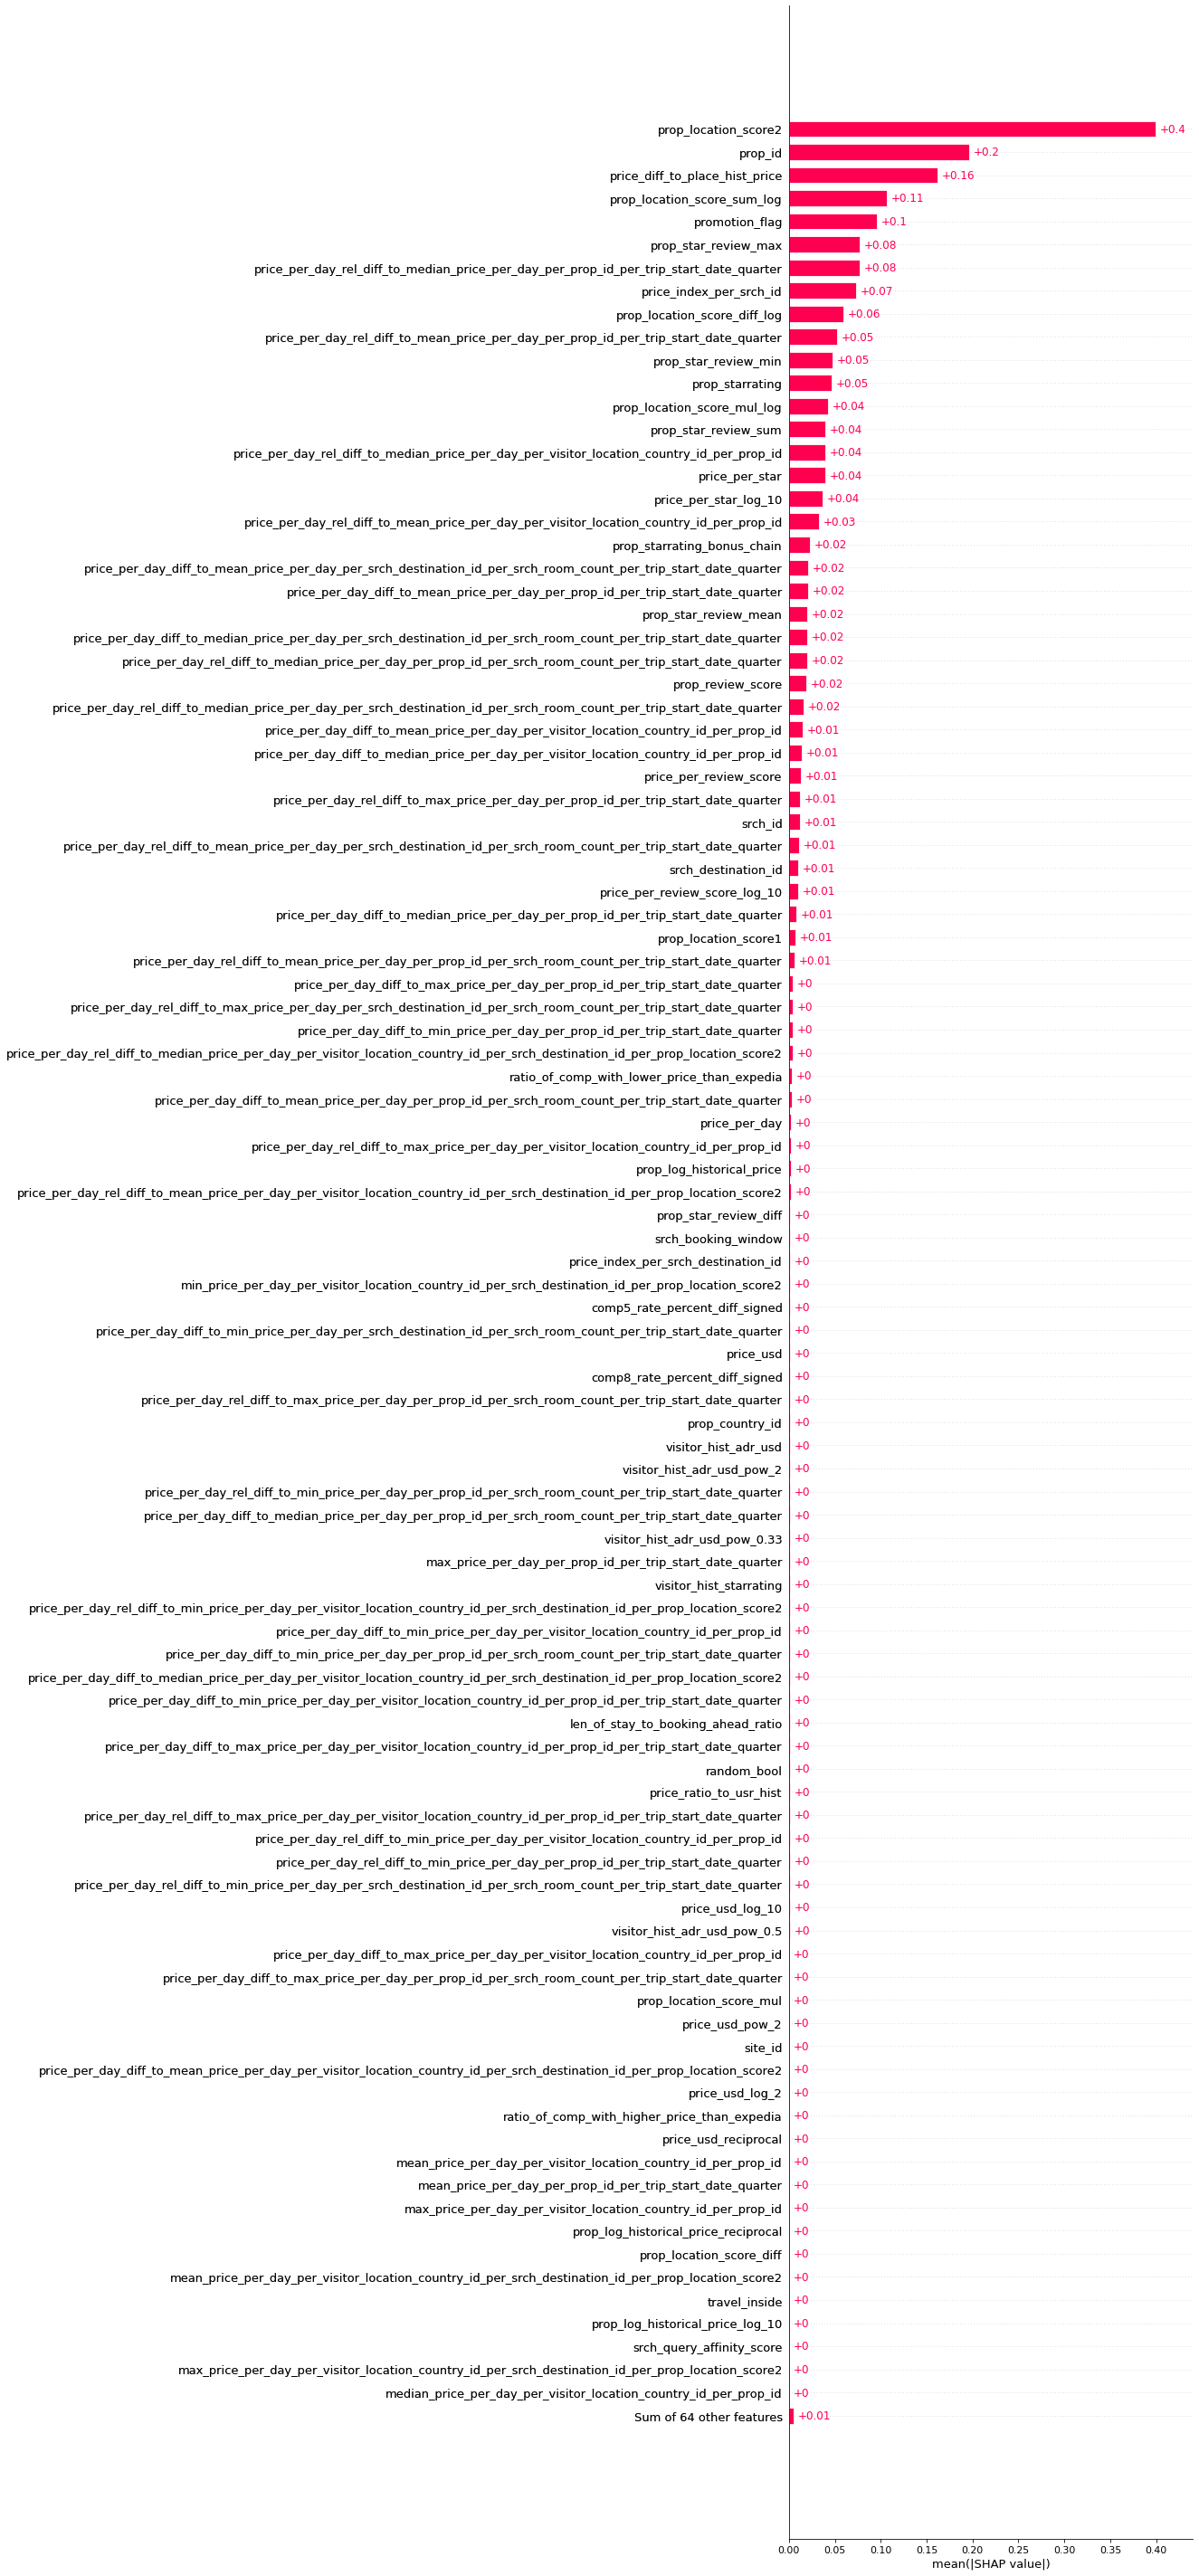

In [49]:
shap.plots.bar(shap_values, max_display=100)

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with shap.TreeExplainer(model).shap_interaction_values(X). This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships

https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

In [50]:
shap.TreeExplainer(model).shap_interaction_values(X_val.head(10))

AttributeError: 'TreeEnsemble' object has no attribute 'values'

In [ ]:
# feature_score_PredictionValuesChange = get_and_plot_feature_imp_catboost(
#         model, X_val, y_val,
#         cat_features=CAT_FEATURES,
#         method='PredictionValuesChange',
#         top_n=COLLECT_N_IMPORTANT_FEATURES)

#     important_features_collected.update(feature_score_PredictionValuesChange.sort_values(['Score'], ascending=False).values[:COLLECT_N_IMPORTANT_FEATURES, 0])